In [ ]:
# !curl -Os https://s3.amazonaws.com/google-landmark/metadata/train.csv > train.csv
# !curl -Os  https://s3.amazonaws.com/google-landmark/metadata/train_clean.csv > train_clean.csv
# !curl -Os https://s3.amazonaws.com/google-landmark/ground_truth/recognition_solution_v2.1.csv > recognition_solution_v2.1.csv

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
bucket_name = 'gld_v2' 
PROJECT_ID = 'rational-moon-286222'
from google.cloud import storage
storage_client = storage.Client(project=PROJECT_ID)

def upload_blob( source_file_name, destination_blob_name,bucket_name=bucket_name,verb=True):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)
    blob.upload_from_filename(source_file_name)
    if verb: print('File {} uploaded to {}.'.format(source_file_name,destination_blob_name))

def download_blob( source_blob_name, destination_file_name,bucket_name=bucket_name,verb=True):
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    if verb: print('File {} downloaded from {}.'.format(destination_file_name,source_blob_name))

In [ ]:
download_blob("recognition_solution_v2.1.csv","test.csv")
download_blob("train_clean_format.csv","train_clean.csv")
download_blob("train_full.csv","train_full.csv")

File test.csv downloaded from recognition_solution_v2.1.csv.
File train_clean.csv downloaded from train_clean_format.csv.
File train_full.csv downloaded from train_full.csv.


setup

In [ ]:
lb_size = 4
div = 10
seed = 1214
np.random.seed=seed

In [ ]:
test = pd.read_csv("test.csv",usecols=["id","landmarks"])
train_clean = pd.read_csv("train_clean.csv")
train_full = pd.read_csv("train_full.csv")

In [ ]:
train_clean.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


Seperate train_clean & not_clean from full

In [ ]:
def anti_join(x, y, on):
    """Return rows in x which are not present in y"""
    ans = pd.merge(left=x, right=y, how='left', indicator=True, on=on)
    ans = ans.loc[ans._merge == 'left_only', :].drop(columns='_merge')
    return ans

In [ ]:
train_out = anti_join(train_full,train_clean[["id"]],["id"])

In [ ]:
assert train_out.shape[0]+train_clean.shape[0]==train_full.shape[0]
train_out.shape[0],train_clean.shape[0],train_full.shape[0]

(2552444, 1580470, 4132914)

In [ ]:
train_clean_count = train_clean.groupby(["landmark_id"]).count()
train_out_count = train_out.groupby(["landmark_id"]).count()
train_clean_count.columns = ["num"]
train_out_count.columns = ["num"]

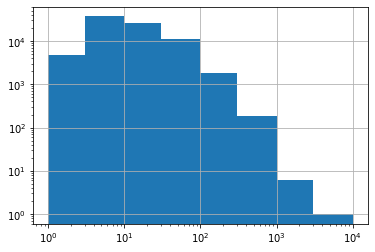

In [ ]:
logbins = [1,3,10,30,100,300,1000,3000,10000]
train_clean_count.num.hist(bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.show()

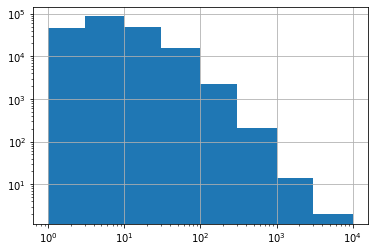

In [ ]:
train_out_count.num.hist(bins=logbins)
plt.xscale('log')
plt.yscale('log')
plt.show()

Generate Train and valid split for both

In [ ]:
def val_num(x):
  return np.where(x<lb_size,np.zeros_like(x),np.ceil(x/div))

train_clean_count["num_val"] = train_clean_count.num.map(val_num).astype("int16")
train_out_count["num_val"] = train_out_count.num.map(val_num).astype("int16")

In [ ]:
def separate_train_val_df(df,df_count,seed=seed):
  rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(seed)))
  groups = df.groupby(["landmark_id"]).groups

  train_li,val_li = [],[]
  for k,row in df_count.iterrows():
    ids = groups[k].values
    rs.shuffle(ids)
    train_li.append(ids[row["num_val"]:])
    val_li.append(ids[:row["num_val"]])
  train_li = np.concatenate(train_li)
  val_li = np.concatenate(val_li)

  return df.loc[train_li],df.loc[val_li]

In [ ]:
df_clean_tr,df_clean_va = separate_train_val_df(train_clean,train_clean_count)
df_out_tr,df_out_va = separate_train_val_df(train_out,train_out_count)

In [ ]:
df_clean_tr.shape[0],df_clean_va.shape[0],df_out_tr.shape[0],df_out_va.shape[0]

(1392698, 187772, 2252318, 300126)

process test

In [ ]:
se = set(train_clean_count.index)
def process(st):
  if st=="nan": return False
  return any(int(i) in se for i in st.split())
def isin(idx):
  return idx in se

In [ ]:
test["has_clean_landmark"] = test.landmarks.astype(str).map(process)
test["has_landmark"] = ~test.landmarks.isnull()
test = test[["id","has_landmark","has_clean_landmark"]]

In [ ]:
sum(test["has_landmark"]),sum(test["has_clean_landmark"]),test.shape[0]

(1972, 1622, 117577)

In [ ]:
df_out_tr["has_clean_landmark"] = df_out_tr.landmark_id.map(isin)
df_out_va["has_clean_landmark"] = df_out_va.landmark_id.map(isin)

In [ ]:
sum(df_out_tr["has_clean_landmark"]),sum(df_out_va["has_clean_landmark"])

(1453953, 188655)

In [ ]:
1642608/2552444

0.6435432079998621

preprocess and upload

In [ ]:
1580470/100,2552444/200,117577/8

(15804.7, 12762.22, 14697.125)

In [ ]:
1392698/15804, 187772/15804, 2252318/12762, 300126/12762
# 88,12,177,24

(88.12313338395343, 11.881295874462161, 176.48628741576556, 23.517160319699105)

In [ ]:
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(seed)))

df_clean_tr = df_clean_tr.sample(frac=1,random_state=rs).reset_index(drop=True)
df_clean_va = df_clean_va.sample(frac=1,random_state=rs).reset_index(drop=True)
df_out_tr = df_out_tr.sample(frac=1,random_state=rs).reset_index(drop=True)
df_out_va = df_out_va.sample(frac=1,random_state=rs).reset_index(drop=True)
test = test.sample(frac=1,random_state=rs).reset_index(drop=True)

In [ ]:
li = [df_clean_tr,df_clean_va,df_out_tr,df_out_va,test]
file = ["df_clean_tr.csv","df_clean_va.csv","df_out_tr.csv","df_out_va.csv","df_test.csv"]

for i,f in zip(li,file):
  i.to_csv(f,index=False)

In [ ]:
for i in file:
  upload_blob(i,i)

File df_clean_tr.csv uploaded to df_clean_tr.csv.
File df_clean_va.csv uploaded to df_clean_va.csv.
File df_out_tr.csv uploaded to df_out_tr.csv.
File df_out_va.csv uploaded to df_out_va.csv.
File df_test.csv uploaded to df_test.csv.
